In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xgboost as xgb
import numpy as np
import prada
import pandas as pd
import veritas
import tree_compress
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', markersize=5)
plt.rc("lines", linewidth=1.0)

## Train models

We use hyperparameter tuning using the grid below to find a reasonable model for each of the datasets.

In [7]:
dnames = ["Chaahat"]
param_dict = {
    "n_estimators": [50, 100],
    "learning_rate": [0.5, 0.2],
    "subsample": [0.5, 0.75, 1.0],
    "max_depth": [6],
}

In [8]:
best_models = {}
dmts = {}
for dname in dnames:
    dmt = prada.get_dataset(dname, nfolds=5, silent=True, seed=12)
    dmt.load_dataset()
    dmt.robust_normalize()
    dmt.astype(np.float64)

    dmts[dname] = dmt

    for target in range(dmt.yscores.shape[1]):
        d = dmt.to_singletarget(target)

        dtrain, dtest = d.train_and_test_fold(0)
        dtrain, dvalid = dtrain.train_and_test_fold(0)
        
        # `model_class` can be any sklearn compatible classifier.
        # There is built-in support for
        #   - rf:  sklearn RandomForest
        #   - xgb: xgboost
        #   - lgb: lightgbm
        model_type = "xgb" # or "rf", "lgb"
        model_class = d.get_model_class(model_type)
    
        models = []
        for i, params in enumerate(d.paramgrid(**param_dict)):
            clf, train_time = dtrain.train(xgb.XGBRegressor, params)
        
            mtrain = dtrain.metric(clf)
            mtest  = dtest.metric(clf)
            mvalid = dvalid.metric(clf)
    
            models.append((d, clf, mtrain, mtest, mvalid, params))
    
        d, clf, mtrain, mtest, mvalid, params = min(models, key=lambda m: m[3])
    
        best_models[d.name()] = (d, clf, mtrain, mtest, mvalid, params)
        print(f"BEST {d.name():15s} train mse {mtrain:.3f}, valid mse {mtrain:.3f}, test mse {mtest:.3f}")
        print("params", params)
        print()

BEST ChaahatRegTarget0 train mse 0.219, valid mse 0.219, test mse 0.325
params {'n_estimators': 100, 'learning_rate': 0.2, 'subsample': 0.75, 'max_depth': 6}

BEST ChaahatRegTarget1 train mse 0.066, valid mse 0.066, test mse 0.102
params {'n_estimators': 100, 'learning_rate': 0.2, 'subsample': 1.0, 'max_depth': 6}

BEST ChaahatRegTarget2 train mse 0.043, valid mse 0.043, test mse 0.071
params {'n_estimators': 100, 'learning_rate': 0.5, 'subsample': 1.0, 'max_depth': 6}

BEST ChaahatRegTarget3 train mse 0.042, valid mse 0.042, test mse 0.080
params {'n_estimators': 100, 'learning_rate': 0.5, 'subsample': 1.0, 'max_depth': 6}

BEST ChaahatRegTarget4 train mse 0.065, valid mse 0.065, test mse 0.109
params {'n_estimators': 100, 'learning_rate': 0.5, 'subsample': 0.75, 'max_depth': 6}



# Compress the models using `tree_compress`

In [5]:
compressed_models = {}
for dname, (d, clf, mtrain, mtest, mvalid, params) in best_models.items():
    dtrain, dtest = d.train_and_test_fold(0)
    dtrain, dvalid = dtrain.train_and_test_fold(0)
    data = tree_compress.Data(
        dtrain.X.to_numpy(), dtrain.y.to_numpy(),
        dtest.X.to_numpy(), dtest.y.to_numpy(),
        dvalid.X.to_numpy(), dvalid.y.to_numpy()
    )
    
    compressed_models[dname] = tree_compress.compress_topdown(
        data, clf, relerr=0.10, silent=False, max_rounds=2,
        return_compress_object=True
    )

    before = compressed_models[dname].records[0]
    after = compressed_models[dname].records[-1]
    print(f"{dname:10s} number of non-zero leaves: {before.nnz_leafs} -> {after.nnz_leafs},",
          f"test accuracy: {before.mtest:.3f} -> {after.mtest:.3f}")


| XGBOOST's base_score
|   base_score diff std      1.9500172359770658e-05 (!) NOT OK
|   base_score reported      142.01552
|   versus manually detected 142.01551913749415
|   abs err                  8.625058569577959e-07
|   rel err                  6.073321119817016e-09
|   base_score OK with relative tolerance 0.001

MODEL PERF: mtr -0.544 mte -0.586 mva -0.592


ROUND 1
Level 0 xxtrain.shape (11478, 100) dense transform time: 0.01s, 4.49s relerr 0.1
 -0.544  -0.592 ->  -0.381  -0.445,   0% removed (alpha=   0.0026, nnz=100/100) fit ok [1.e-03 1.e+04]
 -0.544  -0.592 ->  -0.381  -0.445,   0% removed (alpha=   0.0067, nnz=100/100) fit ok [1.e-03 1.e+04]
 -0.544  -0.592 ->  -0.381  -0.445,   1% removed (alpha=   0.0172, nnz= 99/100) fit ok [1.e-03 1.e+04]
 -0.544  -0.592 ->  -0.381  -0.445,   1% removed (alpha=   0.0444, nnz= 99/100) fit ok [1.e-03 1.e+04]
 -0.544  -0.592 ->  -0.381  -0.445,   2% removed (alpha=   0.1145, nnz= 98/100) fit ok [1.e-03 1.e+04]
 -0.544  -0.592 ->  -0.3

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13201.831433195679, tolerance: 8994.688410835686
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13112.071674870258, tolerance: 8994.688410835686
  model = cd_fast.enet_coordinate_descent_gram(


 -0.544  -0.592 ->  -0.783  -0.847,  62% removed (alpha=  33.8386, nnz=127/330) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -1.293  -1.398,  68% removed (alpha=  87.3326, nnz=107/330) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -1.685  -1.778,  75% removed (alpha= 225.3934, nnz= 81/330) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -2.189  -2.272,  86% removed (alpha= 581.7091, nnz= 47/330) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -2.743  -2.854,  92% removed (alpha=1501.3107, nnz= 25/330) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -3.321  -3.517,  96% removed (alpha=3874.6751, nnz= 14/330) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -0.595  -0.648,  37% removed (alpha=   6.2717, nnz=208/330) fit ok [ 5.0802 33.8386]
 -0.544  -0.592 ->  -0.580  -0.631,  43% removed (alpha=   7.7426, nnz=187/330) fit ok [ 5.0802 33.8386]
 -0.544  -0.592 ->  -0.584  -0.635,  42% removed (alpha=   9.5586, nnz=191/330) fit ok [ 5.0802 33.8386]
 -0.544  -0.592 ->  -0.598  -0.646,  46% removed (alpha=  11.8004, 

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10257.984710048784, tolerance: 8994.688410835686
  model = cd_fast.enet_coordinate_descent_gram(


 -0.544  -0.592 ->  -0.591  -0.671,  49% removed (alpha=  10.3990, nnz=167/330) over   [ 9.5586 14.568 ]
 -0.544  -0.592 ->  -0.592  -0.672,  49% removed (alpha=  11.3134, nnz=169/330) over   [ 9.5586 14.568 ]
 -0.544  -0.592 ->  -0.593  -0.674,  48% removed (alpha=  12.3082, nnz=171/330) over   [ 9.5586 14.568 ]
 -0.544  -0.592 ->  -0.596  -0.677,  49% removed (alpha=  13.3905, nnz=169/330) over   [ 9.5586 14.568 ]
METRICS orig   tr -0.544, va -0.592 [te -0.586],  ntrees 100,  nnodes  8958,  nleafs  4529,  nnz  4527
METRICS prev   tr -0.544, va -0.609 [te -0.613],  ntrees  24,  nnodes  1768,  nleafs   896,  nnz   886
METRICS now    tr -0.577, va -0.645 [te -0.640],  ntrees  24,  nnodes  1466,  nleafs   745,  nnz   717

Level 4 xxtrain.shape (11478, 490) dense transform time: 0.01s, 1.30s relerr 0.1
 -0.544  -0.592 ->  -0.494  -0.533,   0% removed (alpha=   0.0026, nnz=490/490) fit ok [1.e-03 1.e+04]
 -0.544  -0.592 ->  -0.494  -0.533,   0% removed (alpha=   0.0067, nnz=490/490) fit ok

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11541.645863957694, tolerance: 8994.688410835686
  model = cd_fast.enet_coordinate_descent_gram(


 -0.544  -0.592 ->  -0.633  -0.685,  55% removed (alpha=  13.1113, nnz=221/490) under  [1.e-03 1.e+04]


/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17020.400219765837, tolerance: 8994.688410835686
  model = cd_fast.enet_coordinate_descent_gram(


 -0.544  -0.592 ->  -0.828  -0.855,  64% removed (alpha=  33.8386, nnz=174/490) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -1.108  -1.121,  72% removed (alpha=  87.3326, nnz=139/490) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -1.664  -1.691,  79% removed (alpha= 225.3934, nnz=105/490) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -2.495  -2.504,  86% removed (alpha= 581.7091, nnz= 70/490) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -3.952  -4.012,  90% removed (alpha=1501.3107, nnz= 48/490) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -6.954  -7.403,  93% removed (alpha=3874.6751, nnz= 35/490) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -0.622  -0.663,  31% removed (alpha=   2.4301, nnz=339/490) under  [ 1.9684 13.1113]
 -0.544  -0.592 ->  -0.546  -0.580,  36% removed (alpha=   3.0000, nnz=313/490) fit ok [ 1.9684 13.1113]
 -0.544  -0.592 ->  -0.550  -0.584,  37% removed (alpha=   3.7036, nnz=309/490) fit ok [ 1.9684 13.1113]
 -0.544  -0.592 ->  -0.557  -0.592,  39% removed (alpha=   4.5723, 

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9553.892401724857, tolerance: 8994.688410835686
  model = cd_fast.enet_coordinate_descent_gram(


 -0.544  -0.592 ->  -0.613  -0.658,  47% removed (alpha=  33.8386, nnz= 83/158) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -0.696  -0.727,  53% removed (alpha=  87.3326, nnz= 75/158) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -0.957  -0.969,  61% removed (alpha= 225.3934, nnz= 62/158) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -1.580  -1.550,  71% removed (alpha= 581.7091, nnz= 46/158) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -2.557  -2.514,  82% removed (alpha=1501.3107, nnz= 28/158) under  [1.e-03 1.e+04]
 -0.544  -0.592 ->  -4.242  -4.162,  88% removed (alpha=3874.6751, nnz= 19/158) under  [1.e-03 1.e+04]
METRICS orig   tr -0.544, va -0.592 [te -0.586],  ntrees 100,  nnodes  8958,  nleafs  4529,  nnz  4527
METRICS prev   tr -0.602, va -0.650 [te -0.652],  ntrees  24,  nnodes   888,  nleafs   456,  nnz   281
METRICS now    tr -0.602, va -0.650 [te -0.652],  ntrees  24,  nnodes   888,  nleafs   456,  nnz   281

Level 3 xxtrain.shape (11478, 262) dense transform time: 0.00s, 1.22s re

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1510.4727234994657, tolerance: 1418.6648350597
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2176.1222640992846, tolerance: 1418.6648350597
  model = cd_fast.enet_coordinate_descent_gram(


 -0.172  -0.212 ->  -0.241  -0.284,  61% removed (alpha=   5.0802, nnz=157/401) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.310  -0.366,  72% removed (alpha=  13.1113, nnz=111/401) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.448  -0.519,  82% removed (alpha=  33.8386, nnz= 72/401) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.664  -0.833,  85% removed (alpha=  87.3326, nnz= 60/401) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -1.040  -1.314,  90% removed (alpha= 225.3934, nnz= 40/401) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -1.344  -1.572,  94% removed (alpha= 581.7091, nnz= 23/401) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -1.699  -1.835,  96% removed (alpha=1501.3107, nnz= 15/401) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -2.450  -2.499,  97% removed (alpha=3874.6751, nnz= 12/401) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.178  -0.227,  19% removed (alpha=   0.3648, nnz=324/401) fit ok [0.2955 1.9684]
 -0.172  -0.212 ->  -0.178  -0.226,  20% removed (alpha=   0.4504, nnz=32

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2097.001638303267, tolerance: 1418.6648350597
  model = cd_fast.enet_coordinate_descent_gram(


 -0.172  -0.212 ->  -0.267  -0.300,  65% removed (alpha=   5.0802, nnz=204/578) under  [1.e-03 1.e+04]


/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3554.8360842864604, tolerance: 1418.6648350597
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6335.343299577675, tolerance: 1418.6648350597
  model = cd_fast.enet_coordinate_descent_gram(


 -0.172  -0.212 ->  -0.359  -0.393,  72% removed (alpha=  13.1113, nnz=162/578) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.481  -0.515,  82% removed (alpha=  33.8386, nnz=105/578) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.659  -0.695,  86% removed (alpha=  87.3326, nnz= 83/578) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.953  -1.023,  90% removed (alpha= 225.3934, nnz= 55/578) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -1.463  -1.609,  93% removed (alpha= 581.7091, nnz= 39/578) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -2.405  -2.554,  97% removed (alpha=1501.3107, nnz= 19/578) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -4.215  -4.379,  98% removed (alpha=3874.6751, nnz= 14/578) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.177  -0.244,  31% removed (alpha=   0.3648, nnz=401/578) over   [0.2955 1.9684]
 -0.172  -0.212 ->  -0.178  -0.244,  30% removed (alpha=   0.4504, nnz=403/578) over   [0.2955 1.9684]
 -0.172  -0.212 ->  -0.173  -0.233,  38% removed (alpha=   0.5560, nnz=35

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1637.4054603199818, tolerance: 1418.6648350597
  model = cd_fast.enet_coordinate_descent_gram(


 -0.172  -0.212 ->  -0.248  -0.291,  68% removed (alpha=   5.0802, nnz=241/742) under  [1.e-03 1.e+04]


/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2011.5984013172715, tolerance: 1418.6648350597
  model = cd_fast.enet_coordinate_descent_gram(


 -0.172  -0.212 ->  -0.317  -0.347,  75% removed (alpha=  13.1113, nnz=183/742) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.433  -0.465,  83% removed (alpha=  33.8386, nnz=126/742) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.574  -0.621,  88% removed (alpha=  87.3326, nnz= 89/742) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.870  -0.979,  91% removed (alpha= 225.3934, nnz= 68/742) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -1.255  -1.428,  94% removed (alpha= 581.7091, nnz= 45/742) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -1.964  -2.169,  96% removed (alpha=1501.3107, nnz= 31/742) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -3.288  -3.519,  97% removed (alpha=3874.6751, nnz= 23/742) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.169  -0.226,  32% removed (alpha=   0.3648, nnz=502/742) fit ok [0.2955 1.9684]
 -0.172  -0.212 ->  -0.164  -0.221,  39% removed (alpha=   0.4504, nnz=454/742) fit ok [0.2955 1.9684]
 -0.172  -0.212 ->  -0.161  -0.219,  46% removed (alpha=   0.5560, nnz=39

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1722.995298114438, tolerance: 1418.6648350597
  model = cd_fast.enet_coordinate_descent_gram(


 -0.172  -0.212 ->  -0.224  -0.278,  43% removed (alpha=   5.0802, nnz=170/297) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.309  -0.347,  65% removed (alpha=  13.1113, nnz=105/297) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.432  -0.467,  75% removed (alpha=  33.8386, nnz= 75/297) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.615  -0.648,  82% removed (alpha=  87.3326, nnz= 52/297) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.864  -0.928,  88% removed (alpha= 225.3934, nnz= 36/297) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -1.317  -1.484,  91% removed (alpha= 581.7091, nnz= 28/297) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -1.973  -2.138,  93% removed (alpha=1501.3107, nnz= 21/297) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -3.106  -3.289,  93% removed (alpha=3874.6751, nnz= 20/297) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.172  -0.222,  29% removed (alpha=   0.3648, nnz=212/297) fit ok [0.2955 1.9684]
 -0.172  -0.212 ->  -0.172  -0.222,  26% removed (alpha=   0.4504, nnz=21

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2122.8427242411663, tolerance: 1418.6648350597
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3018.80517285897, tolerance: 1418.6648350597
  model = cd_fast.enet_coordinate_descent_gram(


 -0.172  -0.212 ->  -0.235  -0.287,  56% removed (alpha=   5.0802, nnz=180/410) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.326  -0.370,  63% removed (alpha=  13.1113, nnz=152/410) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.455  -0.496,  74% removed (alpha=  33.8386, nnz=105/410) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.679  -0.709,  79% removed (alpha=  87.3326, nnz= 88/410) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.956  -0.989,  86% removed (alpha= 225.3934, nnz= 59/410) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -1.480  -1.522,  90% removed (alpha= 581.7091, nnz= 40/410) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -2.396  -2.444,  95% removed (alpha=1501.3107, nnz= 22/410) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -3.830  -3.961,  96% removed (alpha=3874.6751, nnz= 16/410) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.196  -0.247,  24% removed (alpha=   0.3284, nnz=311/410) under  [0.2955 0.7627]
 -0.172  -0.212 ->  -0.196  -0.247,  24% removed (alpha=   0.3648, nnz=31

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1692.6599274567031, tolerance: 1418.6648350597
  model = cd_fast.enet_coordinate_descent_gram(


 -0.172  -0.212 ->  -0.230  -0.277,  54% removed (alpha=   5.0802, nnz=235/508) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.310  -0.349,  62% removed (alpha=  13.1113, nnz=194/508) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.432  -0.461,  75% removed (alpha=  33.8386, nnz=127/508) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.640  -0.686,  81% removed (alpha=  87.3326, nnz= 97/508) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.983  -1.088,  89% removed (alpha= 225.3934, nnz= 57/508) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -1.388  -1.477,  92% removed (alpha= 581.7091, nnz= 40/508) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -2.531  -2.623,  95% removed (alpha=1501.3107, nnz= 27/508) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -3.675  -3.773,  96% removed (alpha=3874.6751, nnz= 22/508) under  [1.e-03 1.e+04]
 -0.172  -0.212 ->  -0.176  -0.232,  18% removed (alpha=   0.3648, nnz=419/508) fit ok [0.2955 1.9684]
 -0.172  -0.212 ->  -0.176  -0.232,  21% removed (alpha=   0.4504, nnz=40

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 487.77802510163565, tolerance: 481.2383887192011
  model = cd_fast.enet_coordinate_descent_gram(


 -0.130  -0.149 ->  -0.789  -0.796,  98% removed (alpha=1501.3107, nnz=  4/178) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.853  -0.865,  98% removed (alpha=3874.6751, nnz=  4/178) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.130  -0.152,  17% removed (alpha=   0.3648, nnz=148/178) fit ok [0.2955 1.9684]
 -0.130  -0.149 ->  -0.130  -0.153,  15% removed (alpha=   0.4504, nnz=151/178) fit ok [0.2955 1.9684]
 -0.130  -0.149 ->  -0.132  -0.154,  16% removed (alpha=   0.5560, nnz=149/178) fit ok [0.2955 1.9684]
 -0.130  -0.149 ->  -0.134  -0.156,  17% removed (alpha=   0.6864, nnz=147/178) fit ok [0.2955 1.9684]
 -0.130  -0.149 ->  -0.136  -0.159,  19% removed (alpha=   0.8474, nnz=144/178) fit ok [0.2955 1.9684]
 -0.130  -0.149 ->  -0.138  -0.160,  28% removed (alpha=   1.0462, nnz=129/178) fit ok [0.2955 1.9684]
 -0.130  -0.149 ->  -0.142  -0.165,  33% removed (alpha=   1.2915, nnz=119/178) over   [0.2955 1.9684]
 -0.130  -0.149 ->  -0.146  -0.170,  38% removed (alpha=   1.5945, nnz=11

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 721.6436235427697, tolerance: 481.2383887192011
  model = cd_fast.enet_coordinate_descent_gram(


 -0.130  -0.149 ->  -0.208  -0.231,  53% removed (alpha=   5.0802, nnz=141/299) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.283  -0.302,  65% removed (alpha=  13.1113, nnz=106/299) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.399  -0.403,  74% removed (alpha=  33.8386, nnz= 79/299) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.511  -0.506,  86% removed (alpha=  87.3326, nnz= 42/299) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.619  -0.614,  91% removed (alpha= 225.3934, nnz= 27/299) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.816  -0.823,  95% removed (alpha= 581.7091, nnz= 15/299) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -1.266  -1.290,  97% removed (alpha=1501.3107, nnz= 10/299) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -1.921  -1.944,  97% removed (alpha=3874.6751, nnz=  8/299) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.135  -0.158,  21% removed (alpha=   0.3648, nnz=235/299) fit ok [0.2955 1.9684]
 -0.130  -0.149 ->  -0.131  -0.154,  24% removed (alpha=   0.4504, nnz=22

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 832.9831285573441, tolerance: 481.2383887192011
  model = cd_fast.enet_coordinate_descent_gram(


 -0.130  -0.149 ->  -0.212  -0.232,  58% removed (alpha=   5.0802, nnz=190/453) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.279  -0.291,  70% removed (alpha=  13.1113, nnz=137/453) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.357  -0.367,  78% removed (alpha=  33.8386, nnz= 98/453) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.562  -0.597,  85% removed (alpha=  87.3326, nnz= 67/453) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.815  -0.890,  91% removed (alpha= 225.3934, nnz= 42/453) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -1.179  -1.291,  94% removed (alpha= 581.7091, nnz= 25/453) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -1.522  -1.613,  97% removed (alpha=1501.3107, nnz= 15/453) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -2.402  -2.467,  97% removed (alpha=3874.6751, nnz= 13/453) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.129  -0.154,  28% removed (alpha=   0.3648, nnz=324/453) fit ok [0.2955 1.9684]
 -0.130  -0.149 ->  -0.130  -0.156,  30% removed (alpha=   0.4504, nnz=31

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 865.8381614956043, tolerance: 481.2383887192011
  model = cd_fast.enet_coordinate_descent_gram(


 -0.130  -0.149 ->  -0.199  -0.233,  58% removed (alpha=   5.0802, nnz=227/539) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.269  -0.295,  68% removed (alpha=  13.1113, nnz=175/539) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.377  -0.404,  79% removed (alpha=  33.8386, nnz=111/539) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.616  -0.695,  86% removed (alpha=  87.3326, nnz= 75/539) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.923  -1.018,  92% removed (alpha= 225.3934, nnz= 42/539) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -1.346  -1.436,  94% removed (alpha= 581.7091, nnz= 33/539) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -2.588  -2.682,  95% removed (alpha=1501.3107, nnz= 26/539) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -3.450  -3.537,  98% removed (alpha=3874.6751, nnz= 13/539) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.129  -0.150,  34% removed (alpha=   0.3648, nnz=356/539) fit ok [0.2955 1.9684]
 -0.130  -0.149 ->  -0.131  -0.152,  34% removed (alpha=   0.4504, nnz=35

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523.1346862806563, tolerance: 481.2383887192011
  model = cd_fast.enet_coordinate_descent_gram(


 -0.130  -0.149 ->  -0.206  -0.228,  58% removed (alpha=  13.1113, nnz= 68/161) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.280  -0.298,  65% removed (alpha=  33.8386, nnz= 57/161) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.424  -0.440,  75% removed (alpha=  87.3326, nnz= 41/161) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.562  -0.579,  83% removed (alpha= 225.3934, nnz= 27/161) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.829  -0.857,  91% removed (alpha= 581.7091, nnz= 15/161) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -1.098  -1.139,  94% removed (alpha=1501.3107, nnz= 10/161) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -1.709  -1.775,  96% removed (alpha=3874.6751, nnz=  7/161) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.137  -0.162,  32% removed (alpha=   0.8474, nnz=109/161) fit ok [0.7627 1.9684]
 -0.130  -0.149 ->  -0.138  -0.163,  32% removed (alpha=   0.9416, nnz=109/161) fit ok [0.7627 1.9684]
 -0.130  -0.149 ->  -0.138  -0.163,  33% removed (alpha=   1.0462, nnz=10

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 490.6537789303662, tolerance: 481.2383887192011
  model = cd_fast.enet_coordinate_descent_gram(


 -0.130  -0.149 ->  -0.190  -0.207,  46% removed (alpha=   5.0802, nnz=178/330) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.256  -0.269,  58% removed (alpha=  13.1113, nnz=139/330) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.397  -0.411,  68% removed (alpha=  33.8386, nnz=104/330) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.591  -0.610,  78% removed (alpha=  87.3326, nnz= 72/330) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.833  -0.865,  88% removed (alpha= 225.3934, nnz= 40/330) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -1.184  -1.207,  91% removed (alpha= 581.7091, nnz= 31/330) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -1.796  -1.803,  95% removed (alpha=1501.3107, nnz= 18/330) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -2.934  -2.957,  96% removed (alpha=3874.6751, nnz= 12/330) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.138  -0.162,  12% removed (alpha=   0.1414, nnz=289/330) fit ok [0.1145 0.7627]
 -0.130  -0.149 ->  -0.138  -0.162,  16% removed (alpha=   0.1745, nnz=27

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 855.0662372152706, tolerance: 481.2383887192011
  model = cd_fast.enet_coordinate_descent_gram(


 -0.130  -0.149 ->  -0.263  -0.276,  57% removed (alpha=  13.1113, nnz=160/373) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.367  -0.390,  71% removed (alpha=  33.8386, nnz=107/373) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.522  -0.540,  82% removed (alpha=  87.3326, nnz= 69/373) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.835  -0.828,  89% removed (alpha= 225.3934, nnz= 41/373) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -1.239  -1.249,  92% removed (alpha= 581.7091, nnz= 31/373) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -2.208  -2.298,  95% removed (alpha=1501.3107, nnz= 20/373) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -3.618  -3.741,  97% removed (alpha=3874.6751, nnz= 11/373) under  [1.e-03 1.e+04]
 -0.130  -0.149 ->  -0.139  -0.154,  10% removed (alpha=   0.1414, nnz=334/373) fit ok [0.1145 0.7627]
 -0.130  -0.149 ->  -0.136  -0.152,  14% removed (alpha=   0.1745, nnz=321/373) fit ok [0.1145 0.7627]
 -0.130  -0.149 ->  -0.136  -0.152,  15% removed (alpha=   0.2154, nnz=31

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313.32103494794404, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.367  -0.373,  82% removed (alpha=  87.3326, nnz= 23/128) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.541  -0.560,  88% removed (alpha= 225.3934, nnz= 15/128) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.687  -0.715,  95% removed (alpha= 581.7091, nnz=  7/128) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.804  -0.833,  97% removed (alpha=1501.3107, nnz=  4/128) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.971  -1.018,  98% removed (alpha=3874.6751, nnz=  2/128) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.144  -0.163,  22% removed (alpha=   0.9416, nnz=100/128) fit ok [0.7627 5.0802]
 -0.141  -0.160 ->  -0.146  -0.165,  19% removed (alpha=   1.1624, nnz=104/128) fit ok [0.7627 5.0802]
 -0.141  -0.160 ->  -0.148  -0.166,  23% removed (alpha=   1.4350, nnz= 99/128) fit ok [0.7627 5.0802]
 -0.141  -0.160 ->  -0.150  -0.168,  27% removed (alpha=   1.7716, nnz= 94/128) fit ok [0.7627 5.0802]
 -0.141  -0.160 ->  -0.152  -0.170,  32% removed (alpha=   2.1871, nnz= 8

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324.2516943599198, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.319  -0.325,  74% removed (alpha=  33.8386, nnz= 47/182) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.450  -0.457,  84% removed (alpha=  87.3326, nnz= 30/182) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.566  -0.584,  90% removed (alpha= 225.3934, nnz= 18/182) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.730  -0.751,  95% removed (alpha= 581.7091, nnz=  9/182) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.900  -0.919,  97% removed (alpha=1501.3107, nnz=  5/182) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.995  -1.028,  97% removed (alpha=3874.6751, nnz=  5/182) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.137  -0.156,  21% removed (alpha=   0.9416, nnz=143/182) fit ok [0.7627 5.0802]
 -0.141  -0.160 ->  -0.139  -0.160,  26% removed (alpha=   1.1624, nnz=135/182) fit ok [0.7627 5.0802]
 -0.141  -0.160 ->  -0.143  -0.163,  30% removed (alpha=   1.4350, nnz=127/182) fit ok [0.7627 5.0802]
 -0.141  -0.160 ->  -0.148  -0.168,  32% removed (alpha=   1.7716, nnz=12

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352.487379732132, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 492.44569457069815, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.146  -0.164,  27% removed (alpha=   0.7627, nnz=214/294) fit ok [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.167  -0.187,  42% removed (alpha=   1.9684, nnz=171/294) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.205  -0.222,  53% removed (alpha=   5.0802, nnz=138/294) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.283  -0.298,  62% removed (alpha=  13.1113, nnz=112/294) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.408  -0.427,  74% removed (alpha=  33.8386, nnz= 76/294) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.534  -0.560,  82% removed (alpha=  87.3326, nnz= 53/294) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.793  -0.825,  88% removed (alpha= 225.3934, nnz= 36/294) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -1.245  -1.260,  94% removed (alpha= 581.7091, nnz= 19/294) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -1.910  -1.857,  96% removed (alpha=1501.3107, nnz= 11/294) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -2.323  -2.305,  97% removed (alpha=3874.6751, nnz= 1

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316.30010979673904, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.151  -0.170,  33% removed (alpha=   1.0462, nnz=197/294) fit ok [0.2955 1.9684]
 -0.141  -0.160 ->  -0.155  -0.173,  39% removed (alpha=   1.2915, nnz=180/294) fit ok [0.2955 1.9684]
 -0.141  -0.160 ->  -0.159  -0.177,  41% removed (alpha=   1.5945, nnz=174/294) under  [0.2955 1.9684]
 -0.141  -0.160 ->  -0.153  -0.171,  35% removed (alpha=   1.1382, nnz=190/294) fit ok [1.0462 1.5945]
 -0.141  -0.160 ->  -0.154  -0.172,  36% removed (alpha=   1.2383, nnz=187/294) fit ok [1.0462 1.5945]
 -0.141  -0.160 ->  -0.156  -0.174,  38% removed (alpha=   1.3471, nnz=182/294) fit ok [1.0462 1.5945]
 -0.141  -0.160 ->  -0.157  -0.175,  39% removed (alpha=   1.4656, nnz=179/294) fit ok [1.0462 1.5945]
METRICS orig   tr -0.141, va -0.160 [te -0.154],  ntrees 100,  nnodes 10462,  nleafs  5281,  nnz  5278
METRICS prev   tr -0.156, va -0.174 [te -0.169],  ntrees  28,  nnodes  1790,  nleafs   909,  nnz   899
METRICS now    tr -0.157, va -0.175 [te -0.174],  ntrees  28,  nnodes  12

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 353.5599931066522, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.152  -0.173,  35% removed (alpha=   0.7627, nnz=266/407) fit ok [1.e-03 1.e+04]


/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 457.57965499460823, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.177  -0.203,  43% removed (alpha=   1.9684, nnz=233/407) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.219  -0.247,  55% removed (alpha=   5.0802, nnz=183/407) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.295  -0.325,  66% removed (alpha=  13.1113, nnz=139/407) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.421  -0.454,  75% removed (alpha=  33.8386, nnz=101/407) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.631  -0.634,  84% removed (alpha=  87.3326, nnz= 67/407) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.941  -0.903,  87% removed (alpha= 225.3934, nnz= 51/407) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -1.291  -1.218,  93% removed (alpha= 581.7091, nnz= 27/407) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -2.110  -2.014,  97% removed (alpha=1501.3107, nnz= 14/407) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -3.543  -3.425,  98% removed (alpha=3874.6751, nnz= 10/407) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.143  -0.161,  26% removed (alpha=   0.3648, nnz=30

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356.90487207964327, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.150  -0.173,  38% removed (alpha=   0.7627, nnz=337/545) fit ok [1.e-03 1.e+04]


/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 410.82870456126705, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.171  -0.196,  50% removed (alpha=   1.9684, nnz=275/545) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.210  -0.228,  59% removed (alpha=   5.0802, nnz=224/545) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.279  -0.298,  68% removed (alpha=  13.1113, nnz=175/545) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.403  -0.429,  77% removed (alpha=  33.8386, nnz=127/545) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.600  -0.627,  86% removed (alpha=  87.3326, nnz= 78/545) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.870  -0.875,  91% removed (alpha= 225.3934, nnz= 51/545) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -1.315  -1.285,  95% removed (alpha= 581.7091, nnz= 29/545) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -2.059  -1.973,  97% removed (alpha=1501.3107, nnz= 14/545) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -3.338  -3.237,  99% removed (alpha=3874.6751, nnz=  8/545) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.138  -0.160,  34% removed (alpha=   0.3648, nnz=35

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326.82955674299285, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.149  -0.168,  32% removed (alpha=   1.9684, nnz=301/442) fit ok [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.184  -0.196,  42% removed (alpha=   5.0802, nnz=257/442) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.257  -0.267,  55% removed (alpha=  13.1113, nnz=201/442) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.394  -0.409,  67% removed (alpha=  33.8386, nnz=147/442) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.618  -0.642,  78% removed (alpha=  87.3326, nnz= 96/442) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.967  -0.976,  89% removed (alpha= 225.3934, nnz= 50/442) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -1.571  -1.566,  90% removed (alpha= 581.7091, nnz= 42/442) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -2.635  -2.598,  95% removed (alpha=1501.3107, nnz= 23/442) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -3.936  -3.878,  99% removed (alpha=3874.6751, nnz=  5/442) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.140  -0.162,  28% removed (alpha=   0.9416, nnz=31

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315.88214325945717, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.221  -0.237,  49% removed (alpha=  13.1113, nnz= 70/138) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.301  -0.320,  57% removed (alpha=  33.8386, nnz= 60/138) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.424  -0.451,  68% removed (alpha=  87.3326, nnz= 44/138) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.570  -0.603,  80% removed (alpha= 225.3934, nnz= 27/138) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.861  -0.891,  90% removed (alpha= 581.7091, nnz= 14/138) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -1.199  -1.219,  93% removed (alpha=1501.3107, nnz=  9/138) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -1.629  -1.643,  95% removed (alpha=3874.6751, nnz=  7/138) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.155  -0.172,  21% removed (alpha=   0.3648, nnz=109/138) fit ok [0.2955 1.9684]
 -0.141  -0.160 ->  -0.155  -0.172,  22% removed (alpha=   0.4504, nnz=107/138) fit ok [0.2955 1.9684]
 -0.141  -0.160 ->  -0.155  -0.172,  22% removed (alpha=   0.5560, nnz=10

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 370.35861996099686, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.0454040599568, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.158  -0.173,  22% removed (alpha=   0.7627, nnz=164/211) fit ok [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.168  -0.183,  32% removed (alpha=   1.9684, nnz=144/211) under  [1.e-03 1.e+04]


/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 385.3614821218412, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.201  -0.209,  35% removed (alpha=   5.0802, nnz=137/211) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.281  -0.285,  52% removed (alpha=  13.1113, nnz=101/211) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.405  -0.409,  71% removed (alpha=  33.8386, nnz= 62/211) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.554  -0.564,  78% removed (alpha=  87.3326, nnz= 47/211) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.735  -0.743,  85% removed (alpha= 225.3934, nnz= 32/211) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -1.077  -1.103,  89% removed (alpha= 581.7091, nnz= 23/211) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -1.536  -1.552,  93% removed (alpha=1501.3107, nnz= 14/211) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -2.815  -2.804,  94% removed (alpha=3874.6751, nnz= 12/211) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.179  -0.180,  15% removed (alpha=   0.3648, nnz=179/211) under  [0.2955 1.9684]
 -0.141  -0.160 ->  -0.179  -0.180,  17% removed (alpha=   0.4504, nnz=17

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 424.3649438146608, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324.3366212275722, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.165  -0.179,  31% removed (alpha=   1.5945, nnz=146/211) under  [0.2955 1.9684]
 -0.141  -0.160 ->  -0.159  -0.174,  24% removed (alpha=   0.9219, nnz=160/211) fit ok [0.8474 1.2915]
 -0.141  -0.160 ->  -0.159  -0.174,  24% removed (alpha=   1.0030, nnz=161/211) fit ok [0.8474 1.2915]
 -0.141  -0.160 ->  -0.159  -0.174,  29% removed (alpha=   1.0912, nnz=150/211) fit ok [0.8474 1.2915]


/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338.0688978669624, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.160  -0.175,  28% removed (alpha=   1.1872, nnz=151/211) fit ok [0.8474 1.2915]
METRICS orig   tr -0.141, va -0.160 [te -0.154],  ntrees 100,  nnodes 10462,  nleafs  5281,  nnz  5278
METRICS prev   tr -0.159, va -0.176 [te -0.175],  ntrees  22,  nnodes   768,  nleafs   395,  nnz   360
METRICS now    tr -0.159, va -0.174 [te -0.172],  ntrees  21,  nnodes   743,  nleafs   382,  nnz   349

Level 4 xxtrain.shape (11478, 301) dense transform time: 0.00s, 1.13s relerr 0.1
 -0.141  -0.160 ->  -0.154  -0.170,   1% removed (alpha=   0.0026, nnz=299/301) fit ok [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.154  -0.170,   1% removed (alpha=   0.0067, nnz=299/301) fit ok [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.150  -0.166,   2% removed (alpha=   0.0172, nnz=296/301) fit ok [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.150  -0.166,   2% removed (alpha=   0.0444, nnz=294/301) fit ok [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.149  -0.166,   4% removed (alpha=   0.1145, nnz=290/301) fit ok [1.e-03

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333.30475167174444, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 439.2289739147263, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.170  -0.191,  34% removed (alpha=   1.9684, nnz=200/301) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.201  -0.222,  45% removed (alpha=   5.0802, nnz=167/301) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.271  -0.289,  54% removed (alpha=  13.1113, nnz=138/301) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.378  -0.401,  68% removed (alpha=  33.8386, nnz= 97/301) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.548  -0.569,  79% removed (alpha=  87.3326, nnz= 64/301) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.831  -0.833,  85% removed (alpha= 225.3934, nnz= 46/301) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -1.361  -1.321,  91% removed (alpha= 581.7091, nnz= 27/301) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -2.019  -1.943,  95% removed (alpha=1501.3107, nnz= 15/301) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -2.954  -2.899,  97% removed (alpha=3874.6751, nnz=  8/301) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.149  -0.166,   7% removed (alpha=   0.1414, nnz=28

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330.1524332146326, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.154  -0.179,  25% removed (alpha=   0.7627, nnz=275/368) over   [1.e-03 1.e+04]


/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 294.013696113892, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.168  -0.190,  36% removed (alpha=   1.9684, nnz=236/368) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.203  -0.219,  46% removed (alpha=   5.0802, nnz=199/368) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.276  -0.287,  58% removed (alpha=  13.1113, nnz=155/368) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.400  -0.416,  70% removed (alpha=  33.8386, nnz=111/368) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.609  -0.632,  81% removed (alpha=  87.3326, nnz= 69/368) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.820  -0.824,  86% removed (alpha= 225.3934, nnz= 50/368) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -1.308  -1.274,  93% removed (alpha= 581.7091, nnz= 27/368) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -2.021  -1.961,  96% removed (alpha=1501.3107, nnz= 16/368) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -3.124  -3.071,  98% removed (alpha=3874.6751, nnz=  9/368) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.147  -0.171,   8% removed (alpha=   0.1414, nnz=33

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340.8667410760909, tolerance: 282.42865642705414
  model = cd_fast.enet_coordinate_descent_gram(


 -0.141  -0.160 ->  -0.155  -0.175,  26% removed (alpha=   1.9684, nnz=266/359) fit ok [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.184  -0.202,  38% removed (alpha=   5.0802, nnz=224/359) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.248  -0.265,  49% removed (alpha=  13.1113, nnz=182/359) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.390  -0.413,  63% removed (alpha=  33.8386, nnz=133/359) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.610  -0.631,  77% removed (alpha=  87.3326, nnz= 83/359) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.911  -0.919,  84% removed (alpha= 225.3934, nnz= 57/359) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -1.567  -1.558,  87% removed (alpha= 581.7091, nnz= 45/359) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -2.612  -2.577,  93% removed (alpha=1501.3107, nnz= 25/359) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -3.936  -3.878,  99% removed (alpha=3874.6751, nnz=  5/359) under  [1.e-03 1.e+04]
 -0.141  -0.160 ->  -0.149  -0.171,  24% removed (alpha=   0.9416, nnz=27

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 587.398140257653, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(


 -0.222  -0.233 ->  -0.308  -0.324,  55% removed (alpha=  33.8386, nnz=43/96) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.403  -0.422,  67% removed (alpha=  87.3326, nnz=32/96) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.503  -0.520,  83% removed (alpha= 225.3934, nnz=16/96) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.672  -0.680,  90% removed (alpha= 581.7091, nnz=10/96) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.886  -0.896,  97% removed (alpha=1501.3107, nnz= 3/96) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.998  -1.008,  98% removed (alpha=3874.6751, nnz= 2/96) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.204  -0.219,  21% removed (alpha=   2.4301, nnz=76/96) fit ok [ 1.9684 13.1113]
 -0.222  -0.233 ->  -0.207  -0.222,  35% removed (alpha=   3.0000, nnz=62/96) fit ok [ 1.9684 13.1113]
 -0.222  -0.233 ->  -0.211  -0.225,  38% removed (alpha=   3.7036, nnz=60/96) fit ok [ 1.9684 13.1113]
 -0.222  -0.233 ->  -0.215  -0.229,  38% removed (alpha=   4.5723, nnz=60/96) fit ok 

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 618.0560838327283, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.2602480039352, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(


 -0.222  -0.233 ->  -0.351  -0.367,  64% removed (alpha=  33.8386, nnz= 46/129) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.441  -0.457,  77% removed (alpha=  87.3326, nnz= 30/129) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.591  -0.606,  84% removed (alpha= 225.3934, nnz= 21/129) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.759  -0.769,  91% removed (alpha= 581.7091, nnz= 12/129) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.957  -0.968,  96% removed (alpha=1501.3107, nnz=  5/129) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -1.044  -1.063,  97% removed (alpha=3874.6751, nnz=  4/129) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.227  -0.238,  33% removed (alpha=   2.4301, nnz= 87/129) fit ok [ 1.9684 13.1113]
 -0.222  -0.233 ->  -0.228  -0.240,  40% removed (alpha=   3.0000, nnz= 78/129) fit ok [ 1.9684 13.1113]
 -0.222  -0.233 ->  -0.232  -0.244,  40% removed (alpha=   3.7036, nnz= 78/129) fit ok [ 1.9684 13.1113]
 -0.222  -0.233 ->  -0.238  -0.249,  41% removed (alpha=   4.5723, 

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 670.1319662156635, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(


 -0.222  -0.233 ->  -0.258  -0.270,  46% removed (alpha=   5.0802, nnz=117/216) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.314  -0.329,  58% removed (alpha=  13.1113, nnz= 91/216) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.381  -0.393,  69% removed (alpha=  33.8386, nnz= 67/216) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.488  -0.500,  78% removed (alpha=  87.3326, nnz= 47/216) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.668  -0.673,  84% removed (alpha= 225.3934, nnz= 34/216) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.976  -0.968,  90% removed (alpha= 581.7091, nnz= 21/216) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -1.543  -1.503,  97% removed (alpha=1501.3107, nnz=  7/216) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -1.650  -1.628,  97% removed (alpha=3874.6751, nnz=  7/216) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.224  -0.234,  23% removed (alpha=   0.9416, nnz=166/216) fit ok [0.7627 5.0802]
 -0.222  -0.233 ->  -0.225  -0.236,  25% removed (alpha=   1.1624, nnz=16

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 581.2320116840771, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 828.2989426421625, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(


 -0.222  -0.233 ->  -0.221  -0.237,  25% removed (alpha=   0.7627, nnz=248/329) fit ok [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.239  -0.253,  33% removed (alpha=   1.9684, nnz=221/329) fit ok [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.275  -0.290,  47% removed (alpha=   5.0802, nnz=175/329) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.334  -0.344,  60% removed (alpha=  13.1113, nnz=133/329) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.464  -0.459,  69% removed (alpha=  33.8386, nnz=103/329) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.751  -0.709,  77% removed (alpha=  87.3326, nnz= 75/329) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -1.127  -1.054,  84% removed (alpha= 225.3934, nnz= 52/329) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -1.584  -1.518,  89% removed (alpha= 581.7091, nnz= 37/329) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -2.179  -2.175,  94% removed (alpha=1501.3107, nnz= 19/329) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -2.921  -2.956,  97% removed (alpha=3874.6751, nnz= 1

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 544.6528722547409, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(


 -0.222  -0.233 ->  -0.224  -0.239,  26% removed (alpha=   0.9416, nnz=244/329) fit ok [0.7627 5.0802]


/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 509.5551224939589, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(


 -0.222  -0.233 ->  -0.227  -0.241,  31% removed (alpha=   1.1624, nnz=227/329) fit ok [0.7627 5.0802]
 -0.222  -0.233 ->  -0.230  -0.245,  35% removed (alpha=   1.4350, nnz=214/329) fit ok [0.7627 5.0802]
 -0.222  -0.233 ->  -0.234  -0.249,  37% removed (alpha=   1.7716, nnz=207/329) fit ok [0.7627 5.0802]
 -0.222  -0.233 ->  -0.240  -0.254,  37% removed (alpha=   2.1871, nnz=207/329) fit ok [0.7627 5.0802]
 -0.222  -0.233 ->  -0.247  -0.262,  39% removed (alpha=   2.7001, nnz=200/329) under  [0.7627 5.0802]
 -0.222  -0.233 ->  -0.255  -0.270,  41% removed (alpha=   3.3333, nnz=195/329) under  [0.7627 5.0802]
 -0.222  -0.233 ->  -0.264  -0.279,  43% removed (alpha=   4.1151, nnz=186/329) under  [0.7627 5.0802]
 -0.222  -0.233 ->  -0.237  -0.251,  36% removed (alpha=   1.9274, nnz=211/329) fit ok [1.7716 2.7001]
 -0.222  -0.233 ->  -0.238  -0.253,  36% removed (alpha=   2.0969, nnz=212/329) fit ok [1.7716 2.7001]
 -0.222  -0.233 ->  -0.241  -0.255,  37% removed (alpha=   2.2812, nnz=20

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 625.8196354160171, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(


 -0.222  -0.233 ->  -0.218  -0.234,  35% removed (alpha=   0.7627, nnz=298/459) fit ok [1.e-03 1.e+04]


/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 964.7725802308646, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(


 -0.222  -0.233 ->  -0.238  -0.248,  43% removed (alpha=   1.9684, nnz=263/459) fit ok [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.277  -0.282,  53% removed (alpha=   5.0802, nnz=217/459) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.357  -0.360,  59% removed (alpha=  13.1113, nnz=187/459) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.492  -0.502,  68% removed (alpha=  33.8386, nnz=148/459) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.743  -0.744,  75% removed (alpha=  87.3326, nnz=113/459) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -1.181  -1.161,  84% removed (alpha= 225.3934, nnz= 74/459) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -2.077  -1.976,  88% removed (alpha= 581.7091, nnz= 54/459) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -3.753  -3.546,  92% removed (alpha=1501.3107, nnz= 39/459) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -6.271  -5.880,  95% removed (alpha=3874.6751, nnz= 22/459) under  [1.e-03 1.e+04]


/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 548.5646633864421, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(


 -0.222  -0.233 ->  -0.221  -0.233,  35% removed (alpha=   0.9416, nnz=298/459) fit ok [0.7627 5.0802]
 -0.222  -0.233 ->  -0.224  -0.236,  37% removed (alpha=   1.1624, nnz=290/459) fit ok [0.7627 5.0802]
 -0.222  -0.233 ->  -0.228  -0.238,  38% removed (alpha=   1.4350, nnz=283/459) fit ok [0.7627 5.0802]
 -0.222  -0.233 ->  -0.232  -0.242,  39% removed (alpha=   1.7716, nnz=278/459) fit ok [0.7627 5.0802]
 -0.222  -0.233 ->  -0.237  -0.247,  42% removed (alpha=   2.1871, nnz=268/459) fit ok [0.7627 5.0802]
 -0.222  -0.233 ->  -0.249  -0.256,  46% removed (alpha=   2.7001, nnz=248/459) under  [0.7627 5.0802]
 -0.222  -0.233 ->  -0.256  -0.263,  48% removed (alpha=   3.3333, nnz=238/459) under  [0.7627 5.0802]
 -0.222  -0.233 ->  -0.264  -0.270,  51% removed (alpha=   4.1151, nnz=227/459) under  [0.7627 5.0802]
 -0.222  -0.233 ->  -0.242  -0.249,  42% removed (alpha=   1.9274, nnz=264/459) fit ok [1.7716 2.7001]
 -0.222  -0.233 ->  -0.243  -0.250,  42% removed (alpha=   2.0969, nnz=26

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 565.6137108840882, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(


 -0.222  -0.233 ->  -0.229  -0.242,  25% removed (alpha=   1.9684, nnz=274/366) fit ok [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.253  -0.269,  30% removed (alpha=   5.0802, nnz=258/366) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.332  -0.351,  41% removed (alpha=  13.1113, nnz=215/366) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.491  -0.524,  53% removed (alpha=  33.8386, nnz=171/366) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.797  -0.871,  66% removed (alpha=  87.3326, nnz=124/366) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -1.292  -1.377,  76% removed (alpha= 225.3934, nnz= 88/366) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -2.176  -2.225,  84% removed (alpha= 581.7091, nnz= 57/366) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -4.305  -4.291,  90% removed (alpha=1501.3107, nnz= 37/366) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -6.934  -6.944,  95% removed (alpha=3874.6751, nnz= 17/366) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.223  -0.237,  19% removed (alpha=   0.9416, nnz=29

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 613.5264911012663, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 711.383222578341, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(


 -0.222  -0.233 ->  -0.243  -0.258,  31% removed (alpha=   5.0802, nnz= 78/113) fit ok [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.262  -0.277,  46% removed (alpha=  13.1113, nnz= 61/113) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.317  -0.332,  50% removed (alpha=  33.8386, nnz= 57/113) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.437  -0.444,  59% removed (alpha=  87.3326, nnz= 46/113) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.603  -0.601,  65% removed (alpha= 225.3934, nnz= 39/113) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.967  -0.954,  73% removed (alpha= 581.7091, nnz= 30/113) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -1.617  -1.583,  84% removed (alpha=1501.3107, nnz= 18/113) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -2.423  -2.432,  86% removed (alpha=3874.6751, nnz= 16/113) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.236  -0.250,  18% removed (alpha=   0.9416, nnz= 93/113) fit ok [0.7627 5.0802]
 -0.222  -0.233 ->  -0.236  -0.250,  17% removed (alpha=   1.1624, nnz= 9

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 740.0177048490914, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 668.3059057806846, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(


 -0.222  -0.233 ->  -0.241  -0.255,  28% removed (alpha=   1.9684, nnz=128/177) fit ok [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.255  -0.269,  38% removed (alpha=   5.0802, nnz=110/177) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.290  -0.303,  44% removed (alpha=  13.1113, nnz= 99/177) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.368  -0.374,  54% removed (alpha=  33.8386, nnz= 82/177) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.506  -0.515,  62% removed (alpha=  87.3326, nnz= 68/177) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.706  -0.731,  71% removed (alpha= 225.3934, nnz= 51/177) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -1.113  -1.147,  77% removed (alpha= 581.7091, nnz= 41/177) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -1.997  -2.065,  85% removed (alpha=1501.3107, nnz= 26/177) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -3.266  -3.311,  92% removed (alpha=3874.6751, nnz= 14/177) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.237  -0.252,  21% removed (alpha=   0.9416, nnz=13

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 576.656879354123, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 830.1717390822157, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(


 -0.222  -0.233 ->  -0.239  -0.254,  27% removed (alpha=   0.7627, nnz=193/263) fit ok [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.250  -0.264,  31% removed (alpha=   1.9684, nnz=182/263) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.268  -0.280,  40% removed (alpha=   5.0802, nnz=157/263) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.331  -0.338,  46% removed (alpha=  13.1113, nnz=141/263) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.445  -0.445,  59% removed (alpha=  33.8386, nnz=107/263) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.660  -0.642,  67% removed (alpha=  87.3326, nnz= 87/263) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -1.159  -1.084,  77% removed (alpha= 225.3934, nnz= 60/263) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -1.905  -1.782,  87% removed (alpha= 581.7091, nnz= 34/263) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -2.480  -2.432,  92% removed (alpha=1501.3107, nnz= 20/263) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -3.392  -3.374,  94% removed (alpha=3874.6751, nnz= 1

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 626.8581769431254, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(


 -0.222  -0.233 ->  -0.234  -0.247,  25% removed (alpha=   0.7627, nnz=238/318) fit ok [1.e-03 1.e+04]


/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 938.2171508991819, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(


 -0.222  -0.233 ->  -0.245  -0.254,  30% removed (alpha=   1.9684, nnz=222/318) fit ok [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.274  -0.277,  37% removed (alpha=   5.0802, nnz=199/318) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.350  -0.345,  43% removed (alpha=  13.1113, nnz=182/318) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.504  -0.489,  56% removed (alpha=  33.8386, nnz=139/318) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.750  -0.746,  66% removed (alpha=  87.3326, nnz=107/318) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -1.274  -1.167,  74% removed (alpha= 225.3934, nnz= 83/318) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -2.067  -1.871,  83% removed (alpha= 581.7091, nnz= 55/318) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -3.641  -3.445,  89% removed (alpha=1501.3107, nnz= 35/318) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -5.570  -5.273,  95% removed (alpha=3874.6751, nnz= 17/318) under  [1.e-03 1.e+04]
 -0.222  -0.233 ->  -0.236  -0.248,  24% removed (alpha=   0.9416, nnz=24

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 585.8732806860298, tolerance: 507.3271805515732
  model = cd_fast.enet_coordinate_descent_gram(


 -0.222  -0.233 ->  -0.242  -0.256,  27% removed (alpha=   2.7001, nnz=225/310) fit ok [0.7627 5.0802]
 -0.222  -0.233 ->  -0.246  -0.260,  28% removed (alpha=   3.3333, nnz=223/310) under  [0.7627 5.0802]
 -0.222  -0.233 ->  -0.250  -0.265,  29% removed (alpha=   4.1151, nnz=219/310) under  [0.7627 5.0802]
 -0.222  -0.233 ->  -0.239  -0.253,  22% removed (alpha=   1.9274, nnz=242/310) fit ok [1.7716 2.7001]
 -0.222  -0.233 ->  -0.240  -0.253,  23% removed (alpha=   2.0969, nnz=239/310) fit ok [1.7716 2.7001]
 -0.222  -0.233 ->  -0.241  -0.254,  24% removed (alpha=   2.2812, nnz=236/310) fit ok [1.7716 2.7001]
 -0.222  -0.233 ->  -0.242  -0.255,  26% removed (alpha=   2.4818, nnz=230/310) fit ok [1.7716 2.7001]
METRICS orig   tr -0.222, va -0.233 [te -0.234],  ntrees 100,  nnodes 10170,  nleafs  5135,  nnz  5133
METRICS prev   tr -0.245, va -0.254 [te -0.261],  ntrees  18,  nnodes   602,  nleafs   310,  nnz   252
METRICS now    tr -0.242, va -0.255 [te -0.258],  ntrees  18,  nnodes   6

In [8]:
# Override metrics, because tree_compress used MSE
for dname, c, (d, clf, mtrain, mtest, mvalid, params) in zip(compressed_models.keys(),
                                                             compressed_models.values(),
                                                             best_models.values()):
    dtrain, dtest = d.train_and_test_fold(0)
    dtrain, dvalid = dtrain.train_and_test_fold(0)
    before = c.records[0]
    after = c.records[-1]

    for rec in [before, after]:
        rec.mtrain = dtrain.metric(rec.at)
        rec.mtest = dtest.metric(rec.at)
        rec.mvalid = dvalid.metric(rec.at)

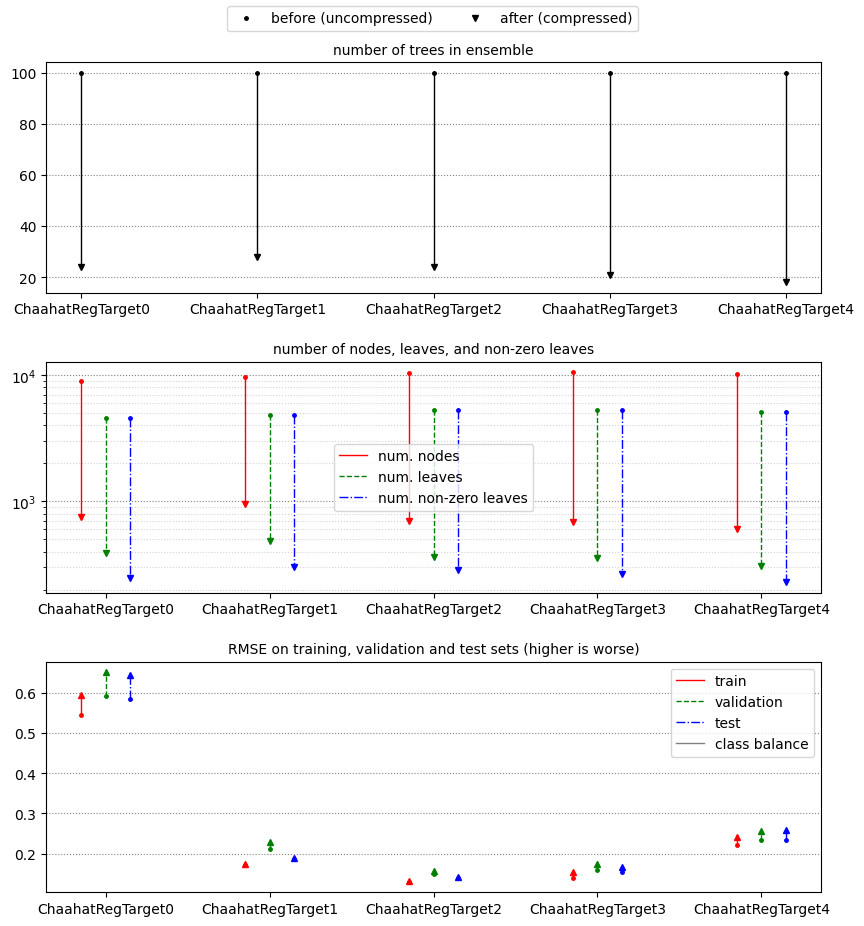

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].set_prop_cycle(color=['black'])
for k in [1, 2]:
    axs[k].set_prop_cycle(color=['red', 'green', 'blue'])

#for k, (dname, c) in enumerate(compressed_models.items()):
for k, dname, c, (d, clf, mtrain, mtest, mvalid, params) in zip(range(len(compressed_models)), compressed_models.keys(), compressed_models.values(), best_models.values()):
    before = c.records[0]
    after = c.records[-1]

    i = k-0.15
    j = k+0.15
    
    lk, = axs[0].plot(k, before.ntrees, ".")
    axs[0].plot(k, after.ntrees, "v", color=lk.get_color())
    axs[0].plot([k, k], [before.ntrees, after.ntrees],
                color=lk.get_color())
    
    li, = axs[1].plot(i, before.nnodes, ".")
    axs[1].plot(i, after.nnodes, "v", color=li.get_color())
    axs[1].plot([i, i], [before.nnodes, after.nnodes], "-",
                color=li.get_color())
    
    lk, = axs[1].plot(k, before.nleafs, ".")
    axs[1].plot(k, after.nleafs, "v", color=lk.get_color())
    axs[1].plot([k, k], [before.nleafs, after.nleafs], "--",
                color=lk.get_color())

    lj, = axs[1].plot(j, before.nnz_leafs, ".")
    axs[1].plot(j, after.nnz_leafs, "v", color=lj.get_color())
    axs[1].plot([j, j], [before.nnz_leafs, after.nnz_leafs], "-.",
                color=lj.get_color())
    
    li, = axs[2].plot(i, before.mtrain, ".")
    axs[2].plot(i, after.mtrain, "^", color=li.get_color())
    axs[2].plot([i, i], [before.mtrain, after.mtrain], "-",
                color=li.get_color())
    
    lk, = axs[2].plot(k, before.mvalid, ".")
    axs[2].plot(k, after.mvalid, "^", color=lk.get_color())
    axs[2].plot([k, k], [before.mvalid, after.mvalid], "--",
                color=lk.get_color())

    lj, = axs[2].plot(j, before.mtest, ".")
    axs[2].plot(j, after.mtest, "^", color=lj.get_color())
    axs[2].plot([j, j], [before.mtest, after.mtest], "-.",
                color=lj.get_color())

for k in [0, 1, 2]:
    axs[k].set_xticks(range(len(compressed_models)))
    axs[k].set_xticklabels(list(compressed_models.keys()))
    axs[k].grid(visible=True, axis="y", ls=":", color="gray", which="major")
    axs[k].grid(visible=True, axis="y", ls=":", color="lightgray", which="minor")

fig.legend([
                Line2D([0], [0], c="black", ls="", marker="."),
                Line2D([0], [0], c="black", ls="", marker="v")
           ], [
                "before (uncompressed)",
                "after (compressed)"
           ], loc="upper center", ncols=2)

axs[1].legend([
                Line2D([0], [0], c="red", ls="-"),
                Line2D([0], [0], c="green", ls="--"),
                Line2D([0], [0], c="blue", ls="-."),
           ], [
                "num. nodes",
                "num. leaves",
                "num. non-zero leaves",
           ])

axs[2].legend([
                Line2D([0], [0], c="red", ls="-"),
                Line2D([0], [0], c="green", ls="--"),
                Line2D([0], [0], c="blue", ls="-."),
                Line2D([0], [0], c="gray", ls="-"),
           ], [
                "train",
                "validation",
                "test",
                "class balance",
           ])

axs[0].set_title("number of trees in ensemble")
axs[1].set_title("number of nodes, leaves, and non-zero leaves")
axs[2].set_title("RMSE on training, validation and test sets (higher is worse)")

axs[1].set_yscale("log")
#axs[0].yaxis.set_minor_locator(MultipleLocator(5))
#axs[2].yaxis.set_minor_locator(MultipleLocator(0.02))

fig.subplots_adjust(top=0.94, hspace=0.3)

plt.show()

In [17]:
index_acc = pd.MultiIndex.from_product((compressed_models.keys(), ["before", "after"]))
df = pd.DataFrame("-", columns=["train", "validation", "test",
                                "ntrees", "nnodes", "nleaves", "nnz_leaves",
                                "nleaf_ratio", "nnz_ratio",
                                "test_ratio"], index=index_acc)

for k, (dname, c) in enumerate(compressed_models.items()):
    before = c.records[0]
    after = c.records[-1]

    rbefore = df.loc[(dname, "before"), :]
    rafter = df.loc[(dname, "after"), :]

    rbefore["train"] = np.round(before.mtrain*100, 1)
    rafter["train"] = np.round(after.mtrain*100, 1)
    rbefore["validation"] = np.round(before.mvalid*100, 1)
    rafter["validation"] = np.round(after.mvalid*100, 1)
    rbefore["test"] = np.round(before.mtest*100, 1)
    rafter["test"] = np.round(after.mtest*100, 1)

    rbefore["ntrees"] = before.ntrees
    rafter[ "ntrees"] = after.ntrees
    rbefore["nnodes"] = before.nnodes
    rafter[ "nnodes"] = after.nnodes
    rbefore["nleaves"] = before.nleafs
    rafter[ "nleaves"] = after.nleafs
    rbefore["nnz_leaves"] = before.nnz_leafs
    rafter[ "nnz_leaves"] = after.nnz_leafs
    rafter[ "nleaf_ratio"] = np.round(before.nleafs / after.nleafs, 2)
    rafter[ "nnz_ratio"] = np.round(before.nnz_leafs / after.nnz_leafs, 2)
    rafter[ "test_ratio"] = 1.0-np.round(after.mtest / before.mtest, 4)

display(df)
df_after = df.xs("after", level=1)
display(df_after[["nleaf_ratio", "nnz_ratio", "test_ratio"]].mean(axis=0))

train validation  test ntrees nnodes nleaves  \
ChaahatRegTarget0 before  54.4       59.2  58.6    100   8958    4529   
                  after   59.5       65.1  64.4     24    752     388   
ChaahatRegTarget1 before  17.2       21.2  18.6    100   9586    4843   
                  after   17.3       23.0  18.8     28    950     489   
ChaahatRegTarget2 before  13.0       14.9  13.9    100  10400    5250   
                  after   13.3       15.7  14.2     24    702     363   
ChaahatRegTarget3 before  14.1       16.0  15.4    100  10462    5281   
                  after   15.3       17.5  16.8     21    691     356   
ChaahatRegTarget4 before  22.2       23.3  23.4    100  10170    5135   
                  after   24.2       25.5  25.8     18    602     310   

                         nnz_leaves nleaf_ratio nnz_ratio test_ratio  
ChaahatRegTarget0 before       4527           -         -          -  
                  after         247       11.67     18.33     -0.099  
ChaahatRegTarget1 before       4837           -         -          -  
                  after         304         9.9     15.91    -0.0116  
ChaahatRegTarget2 before       5242           -         -          -  
                  after         286       14.46     18.33    -0.0178  
ChaahatRegTarget3 before       5278           -         -          -  
                  after         265       14.83     19.92    -0.0903  
ChaahatRegTarget4 before       5133           -         -          -  
                  after         230       16.56     22.32    -0.1033

nleaf_ratio    13.484
nnz_ratio      18.962
test_ratio    -0.0644
dtype: object

# Combine the single-target models into a combined multi-class model

In [12]:
combined_models = {}
for dname in dnames:
    ntargets = sum(1 for k in compressed_models.keys() if k.startswith(dname))
    at_orig = veritas.AddTree(ntargets, veritas.AddTreeType.CLF_SOFTMAX)
    at_comp = veritas.AddTree(ntargets, veritas.AddTreeType.CLF_SOFTMAX)
    for target in range(ntargets):
        key = f"{dname}RegTarget{target}"
        c = compressed_models[key]
        
        before = c.records[0]
        after = c.records[-1]
        
        at_orig.add_trees(before.at, target)
        at_comp.add_trees(after.at, target)
        
    dmt = dmts[dname]
    dtrain, dtest = dmt.train_and_test_fold(0)
    dtrain, dvalid = dtrain.train_and_test_fold(0)

    before = tree_compress.CompressRecord(0, 0.0, at_orig)
    before.mtrain = dtrain.metric(dtrain.y, np.argmax(at_orig.predict(dtrain.X), axis=1))
    before.mtest = dtrain.metric(dtest.y, np.argmax(at_orig.predict(dtest.X), axis=1))
    before.mvalid = dtrain.metric(dvalid.y, np.argmax(at_orig.predict(dvalid.X), axis=1))
    after = tree_compress.CompressRecord(0, 0.0, at_comp)
    after.mtrain = dtrain.metric(dtrain.y, np.argmax(at_comp.predict(dtrain.X), axis=1))
    after.mtest = dtrain.metric(dtest.y, np.argmax(at_comp.predict(dtest.X), axis=1))
    after.mvalid = dtrain.metric(dvalid.y, np.argmax(at_comp.predict(dvalid.X), axis=1))

    combined_models[dname] = [before, after]

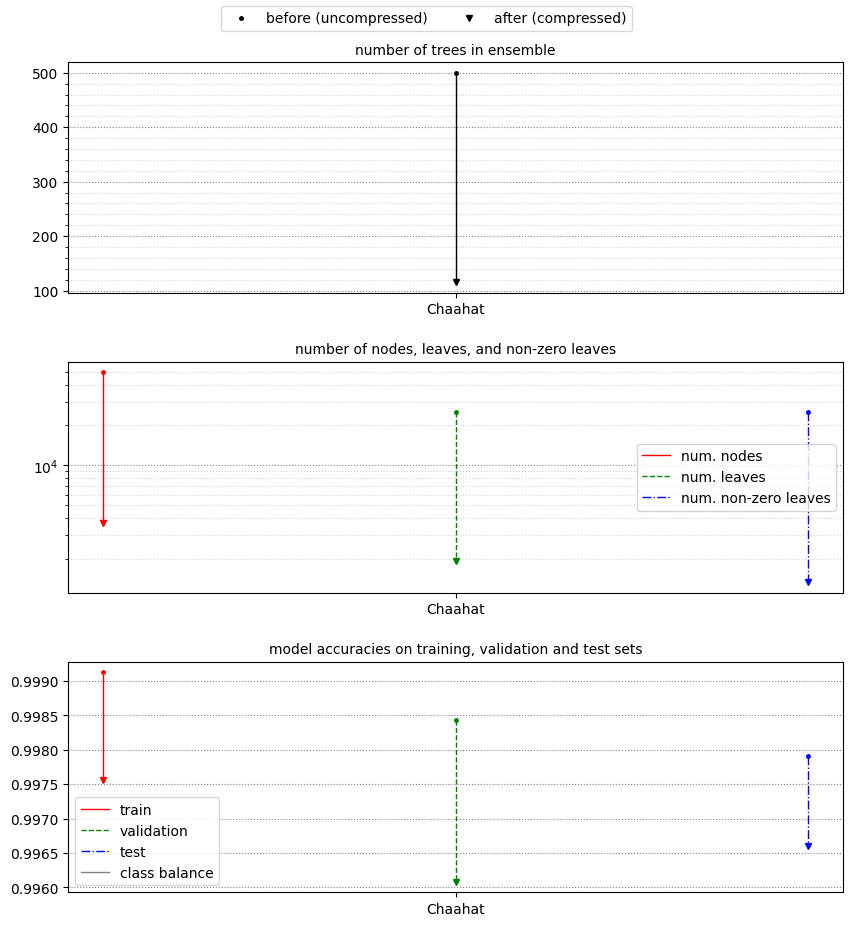

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].set_prop_cycle(color=['black'])
for k in [1, 2]:
    axs[k].set_prop_cycle(color=['red', 'green', 'blue'])

for k, dname, c in zip(range(len(combined_models)),          
                       combined_models.keys(),
                       combined_models.values()):
    dmt = dmts[dname]
    
    before = c[0]
    after = c[-1]

    i = k-0.15
    j = k+0.15
    
    lk, = axs[0].plot(k, before.ntrees, ".")
    axs[0].plot(k, after.ntrees, "v", color=lk.get_color())
    axs[0].plot([k, k], [before.ntrees, after.ntrees],
                color=lk.get_color())
    
    li, = axs[1].plot(i, before.nnodes, ".")
    axs[1].plot(i, after.nnodes, "v", color=li.get_color())
    axs[1].plot([i, i], [before.nnodes, after.nnodes], "-",
                color=li.get_color())
    
    lk, = axs[1].plot(k, before.nleafs, ".")
    axs[1].plot(k, after.nleafs, "v", color=lk.get_color())
    axs[1].plot([k, k], [before.nleafs, after.nleafs], "--",
                color=lk.get_color())

    lj, = axs[1].plot(j, before.nnz_leafs, ".")
    axs[1].plot(j, after.nnz_leafs, "v", color=lj.get_color())
    axs[1].plot([j, j], [before.nnz_leafs, after.nnz_leafs], "-.",
                color=lj.get_color())
    
    li, = axs[2].plot(i, before.mtrain, ".")
    axs[2].plot(i, after.mtrain, "v", color=li.get_color())
    axs[2].plot([i, i], [before.mtrain, after.mtrain], "-",
                color=li.get_color())
    
    lk, = axs[2].plot(k, before.mvalid, ".")
    axs[2].plot(k, after.mvalid, "v", color=lk.get_color())
    axs[2].plot([k, k], [before.mvalid, after.mvalid], "--",
                color=lk.get_color())

    lj, = axs[2].plot(j, before.mtest, ".")
    axs[2].plot(j, after.mtest, "v", color=lj.get_color())
    axs[2].plot([j, j], [before.mtest, after.mtest], "-.",
                color=lj.get_color())

    #classes, class_counts = np.unique(dmt.y, return_counts=True)
    #class_balance = max(class_counts) / sum(class_counts)
    #axs[2].plot([i, j], [class_balance, class_balance], "-", c="gray")

for k in [0, 1, 2]:
    axs[k].set_xticks(range(len(combined_models)))
    axs[k].set_xticklabels(list(combined_models.keys()))
    axs[k].grid(visible=True, axis="y", ls=":", color="gray", which="major")
    axs[k].grid(visible=True, axis="y", ls=":", color="lightgray", which="minor")

fig.legend([
                Line2D([0], [0], c="black", ls="", marker="."),
                Line2D([0], [0], c="black", ls="", marker="v")
           ], [
                "before (uncompressed)",
                "after (compressed)"
           ], loc="upper center", ncols=2)

axs[1].legend([
                Line2D([0], [0], c="red", ls="-"),
                Line2D([0], [0], c="green", ls="--"),
                Line2D([0], [0], c="blue", ls="-."),
           ], [
                "num. nodes",
                "num. leaves",
                "num. non-zero leaves",
           ])

axs[2].legend([
                Line2D([0], [0], c="red", ls="-"),
                Line2D([0], [0], c="green", ls="--"),
                Line2D([0], [0], c="blue", ls="-."),
                Line2D([0], [0], c="gray", ls="-"),
           ], [
                "train",
                "validation",
                "test",
                "class balance",
           ])

axs[0].set_title("number of trees in ensemble")
axs[1].set_title("number of nodes, leaves, and non-zero leaves")
axs[2].set_title("model accuracies on training, validation and test sets")

axs[1].set_yscale("log")
axs[0].yaxis.set_minor_locator(MultipleLocator(20))
axs[2].yaxis.set_minor_locator(MultipleLocator(0.02))

fig.subplots_adjust(top=0.94, hspace=0.3)

plt.show()

In [21]:
index_acc = pd.MultiIndex.from_product((dnames, ["before", "after"]))
df = pd.DataFrame("-", columns=["train", "validation", "test",
                                "ntrees", "nnodes", "nleaves", "nnz_leaves",
                                "nleaf_ratio", "nnz_ratio",
                                "test_ratio"], index=index_acc)

for k, (dname, c) in enumerate(combined_models.items()):
    before = c[0]
    after = c[-1]

    rbefore = df.loc[(dname, "before"), :]
    rafter = df.loc[(dname, "after"), :]

    rbefore["train"] = np.round(before.mtrain*100, 1)
    rafter["train"] = np.round(after.mtrain*100, 1)
    rbefore["validation"] = np.round(before.mvalid*100, 1)
    rafter["validation"] = np.round(after.mvalid*100, 1)
    rbefore["test"] = np.round(before.mtest*100, 1)
    rafter["test"] = np.round(after.mtest*100, 1)

    rbefore["ntrees"] = before.ntrees
    rafter[ "ntrees"] = after.ntrees
    rbefore["nnodes"] = before.nnodes
    rafter[ "nnodes"] = after.nnodes
    rbefore["nleaves"] = before.nleafs
    rafter[ "nleaves"] = after.nleafs
    rbefore["nnz_leaves"] = before.nnz_leafs
    rafter[ "nnz_leaves"] = after.nnz_leafs
    rafter[ "nleaf_ratio"] = np.round(before.nleafs / after.nleafs, 2)
    rafter[ "nnz_ratio"] = np.round(before.nnz_leafs / after.nnz_leafs, 2)
    rafter[ "test_ratio"] = 1.0-np.round(after.mtest / before.mtest, 4)

display(df)
df_after = df.xs("after", level=1)
display(df_after[["nleaf_ratio", "nnz_ratio", "test_ratio"]].mean(axis=0))

train validation  test ntrees nnodes nleaves nnz_leaves  \
Chaahat before  99.9       99.8  99.8    500  49576   25038      25017   
        after   99.8       99.6  99.7    115   3697    1906       1332   

               nleaf_ratio nnz_ratio test_ratio  
Chaahat before           -         -          -  
        after        13.14     18.78     0.0013

nleaf_ratio     13.14
nnz_ratio       18.78
test_ratio     0.0013
dtype: object